# MQI Classification

## Imports

In [1]:
"""Module for MQI Classification Tests Using Cleaned Dataset."""

from io import BytesIO
import base64

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import dataframe_image as dfi
from IPython.display import display, HTML

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

import functions_classification as fn

## Load Datasets

In [2]:
# Full dataset
datos_modificados = pd.read_csv("../data/datos_modificados.csv")

# Datos modificados para MQI (LIMPIOS)
X_mqi_datos = pd.read_csv('../data/mqi/modificados/X_mqi_datos_mod.csv', index_col=0)
X_mqi_norm = pd.read_csv('../data/mqi/modificados/X_mqi_norm_mod.csv', index_col=0)

# Selected data
X_cor_pear = pd.read_csv('../data/mqi/modificados/X_cor_pear_mod.csv', index_col=0)
X_cor_ols = pd.read_csv('../data/mqi/modificados/X_cor_ols_mod.csv', index_col=0)
X_forest = pd.read_csv('../data/mqi/modificados/X_forest_mod.csv', index_col=0)
X_svm = pd.read_csv('../data/mqi/modificados/X_svm_mod.csv', index_col=0)

# PCA data
X_pca_95 = pd.read_csv('../data/mqi/modificados/X_pca_95_mod.csv')

# Features with ranking
feature_ranking = pd.read_csv('../data/mqi/modificados/feature_ranking_mod.csv')
feature_ranking.rename({'Unnamed: 0': 'feat'}, inplace=True, axis=1)

In [3]:
# Subsets using different amount of features from aggregated selected features
X_selected_4 = X_mqi_datos[feature_ranking['feat'][0:4]]
X_selected_8 = X_mqi_datos[feature_ranking['feat'][0:8]]
X_selected_all = X_mqi_datos[feature_ranking['feat']]

In [4]:
# Dependent Variable
Y_mqi = datos_modificados['cut_off_points']

# Class counts
Y_mqi.value_counts()

cut_off_points
3    837
1    215
2    201
Name: count, dtype: int64

In [ ]:
# Dictionariy of datasets
datasets = {
    'X_mqi_datos': X_mqi_datos,
    'X_cor_pear': X_cor_pear,
    'X_cor_ols': X_cor_ols,
    'X_forest': X_forest,
    'X_pca_95': X_pca_95,
    'X_mqi_norm': X_mqi_norm,
    'X_svm': X_svm,
    'X_selected_4': X_selected_4,
    'X_selected_8': X_selected_8,
    'X_selected_all': X_selected_all
}

# Datasets for hyperparameter tuning
datasets_hpt = {
    'X_mqi_datos': X_mqi_datos,
    'X_cor_pear': X_cor_pear,
    'X_cor_ols': X_cor_ols,
    'X_forest': X_forest,
    'X_mqi_norm': X_mqi_norm,
    'X_svm': X_svm,
    'X_selected_4': X_selected_4,
    'X_selected_8': X_selected_8,
    'X_selected_all': X_selected_all
}

In [7]:
# Global variables
METRIC = 'roc_auc'
METRIC_NAME = 'ROC AUC'
RESULTS_MEAN_METRIC = 'mean_test_roc_auc'

# Classification

In [8]:
# Set seed for reproducibility
np.random.seed(42)

# Create pipelines to scale data
mlp_pipe = Pipeline(steps=[("scaler", StandardScaler()),
                           ("mlp", MLPClassifier(max_iter=5000, random_state=42))])

svm_pipe = Pipeline(steps=[("scaler", StandardScaler()),
                           ("svm", svm.SVC(kernel='linear', random_state=42, probability=True))])

dict_classifiers_all = {
    "KNN": KNeighborsClassifier(),
    "GradBst": GradientBoostingClassifier(random_state=42),
    "DT": DecisionTreeClassifier(random_state=42),
    "NB": GaussianNB(),
    "SGD": CalibratedClassifierCV(SGDClassifier(random_state=42, loss='log_loss'), cv=5),
    "RndmFor": RandomForestClassifier(random_state=42),
    "MLP": mlp_pipe,
    "SVM": svm_pipe,
}

## Using all features, including those used in MQI calculation
To see what kind of results we can get if we train models with the variables used in calculating the dependent variable

In [9]:
# List of variables used in calculation
columns_to_drop = ["cut_off_points", "mqi"]

# Drop dependent variables from subset
data = datos_modificados.drop(columns_to_drop, axis=1)

# List of variables to keep
keep_these = ['id_3', 'sexo', 'edad', 'hand_izq', 'hand_drch',
              'músculo_relativ', 'altura', 'peso', 'imc', 'grasa',
              'músculo', 'eq1', 'eq2', 'eq3', 'agil_m_s', 'sarcopenia_v',
              'sarcopenia_handgrip', 'sarcewgsop', 'andar_agil4m', 'sentadilla',
              'mean_power', 'relative_power', 'sppb', 'fragilidad', 'gruposbuena']

# Make subset of the data that includes variables used in MQI calculation
data_w_related_variables = datos_modificados[keep_these]

In [10]:
# Dictionary of datasets, in this case just the one
dataset = {'data': data_w_related_variables}

# Get classification results
results_df, best_model, best_score = fn.baseline_test(dataset,
                                                      Y_mqi,
                                                      dict_classifiers_all)

# Export classification Results
results_df.to_csv('../results/mqi/baseline_all_feat.csv')

# Show the best classifiaction score
fn.get_models_and_scores("limpios", best_model, best_score)

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\d.dequin\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\d.dequin\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


------ DONE ------
Best model(s) for datos limpios:
SVM:data
Highest accuracy: 0.94973



In [ ]:
# Load results
results_df = pd.read_csv('../results/mqi/baseline_all_feat.csv')
results_df = results_df.drop(['dataset'], axis=1)  # Drop dataset column
results_df = results_df.set_index('metric')  # Set index to metric
results_df = np.round(results_df, decimals=5)  # Round to 5 decimals

results_df.loc[METRIC]

MLP        0.98521
SGD        0.96217
KNN        0.83574
SVM        0.99307
GradBst    0.99023
NB         0.88586
DT         0.91349
RndmFor    0.97737
Name: roc_auc, dtype: float64

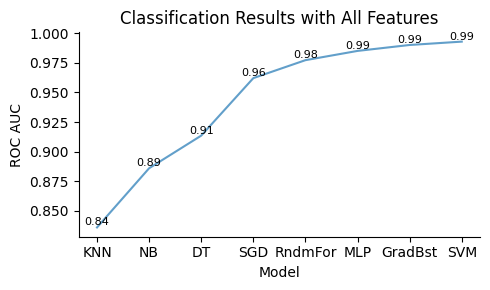

In [12]:
# Load data
results_df = pd.read_csv('../results/mqi/baseline_all_feat.csv')
results_df = results_df.drop(['dataset'], axis=1)
results_df = results_df.set_index('metric')
results_df = np.round(results_df, decimals=5)
results_df.sort_values(METRIC, axis=1, inplace=True)

# Plot results
fig, ax = plt.subplots(figsize=(5, 3))

selected_metric = results_df.loc[METRIC]
selected_metric.plot.line(ax=ax, rot=0, alpha=.7, legend=False)#, width=.8)

# Add labels to each point
for i, value in enumerate(selected_metric):
    ax.text(i, value, f"{value:.2f}", fontsize=8, ha='center', va='bottom')

#results_df.transpose().plot.bar(ax=ax, rot=0, width=.8, alpha=.7, legend=False)
ax.set_title('Classification Results with All Features')
ax.set_ylabel(METRIC_NAME)
ax.set_xlabel('Model')

#ax.bar_label(ax.containers[0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
plt.savefig('../plots/mqi/results_all_feat.png')

# 1. Baseline Test: Compare Model and Dataset Combinations

### Train models

In [13]:
# Baseline comparison results of datos limpios
results_df, best_model, best_score = fn.baseline_test(datasets, Y_mqi, dict_classifiers_all)

# Export Baseline Results
results_df.to_csv('../results/mqi/baseline_mod_limp_kfold.csv')

# Mejores modelos de los resultados de referencia
fn.get_models_and_scores("limpios", best_model, best_score)

  0%|          | 0/10 [00:00<?, ?it/s]

------ DONE ------
Best model(s) for datos limpios:
SGD:X_cor_ols
Highest accuracy: 0.72864



### Load results and compare

In [14]:
# Load results
results_baseline_df = pd.read_csv('../results/mqi/baseline_mod_limp_kfold.csv').ffill().set_index(['dataset', 'metric'])

# Print max and average scores for each model
for col in results_baseline_df.columns:
    average = round(results_baseline_df[col].mean(), 5)

    print(f"{col}:")
    print(f"    ----- Highest score (all metrics): {results_baseline_df[col].max()}")
    print(f"    ----- Average score (all metrics): {average}")

MLP:
    ----- Highest score (all metrics): 0.76635
    ----- Average score (all metrics): 0.57628
SGD:
    ----- Highest score (all metrics): 0.75688
    ----- Average score (all metrics): 0.55807
KNN:
    ----- Highest score (all metrics): 0.67183
    ----- Average score (all metrics): 0.53483
SVM:
    ----- Highest score (all metrics): 0.72892
    ----- Average score (all metrics): 0.53742
GradBst:
    ----- Highest score (all metrics): 0.74422
    ----- Average score (all metrics): 0.5663
NB:
    ----- Highest score (all metrics): 0.71335
    ----- Average score (all metrics): 0.4892
DT:
    ----- Highest score (all metrics): 0.6169
    ----- Average score (all metrics): 0.49845
RndmFor:
    ----- Highest score (all metrics): 0.7401
    ----- Average score (all metrics): 0.57343


### Load baseline results and concat into one dataframe with select metrics

In [53]:
# Load results and filter by selected metrics
# Load results
metrics = ['roc_auc', 'f1', 'accuracy']
results_baseline_df = pd.read_csv('../results/mqi/baseline_mod_limp_kfold.csv').ffill().set_index(['dataset', 'metric'])
results_baseline_df = results_baseline_df.loc(axis=0)[:, metrics].sort_index()

cols = ['SVM', 'NB', 'KNN', 'RndmFor', 'MLP', 'GradBst', 'DT', 'SGD' ]
results_baseline_df = results_baseline_df[cols]
results_baseline_df = results_baseline_df.round(4)

results_baseline_df.to_csv('../results/mqi/baseline_mod_limp_kfold_filtered.csv')
results_baseline_df

SVM      NB     KNN  RndmFor     MLP  GradBst  \
dataset        metric                                                       
X_cor_ols      accuracy  0.7230  0.6672  0.6640   0.7127  0.7246   0.7023   
               f1        0.4538  0.4582  0.4724   0.4932  0.4815   0.4830   
               roc_auc   0.7189  0.7084  0.6718   0.7311  0.7664   0.7377   
X_cor_pear     accuracy  0.6680  0.6759  0.6049   0.6456  0.6664   0.6624   
               f1        0.2669  0.3653  0.3933   0.4086  0.3158   0.3652   
               roc_auc   0.5306  0.6859  0.6091   0.6156  0.6828   0.6646   
X_forest       accuracy  0.7230  0.6680  0.6584   0.7103  0.7191   0.6991   
               f1        0.4526  0.4651  0.4847   0.4981  0.4696   0.4688   
               roc_auc   0.7260  0.7060  0.6644   0.7352  0.7649   0.7378   
X_mqi_datos    accuracy  0.7254  0.2777  0.6560   0.7087  0.7183   0.7015   
               f1        0.4608  0.2124  0.4675   0.4796  0.4769   0.4660   
               roc_auc   0.7280  0.6698  0.6655   0.7297  0.7570   0.7320   
X_mqi_norm     accuracy  0.7238  0.5187  0.6568   0.7063  0.7119   0.7007   
               f1        0.4637  0.4529  0.4574   0.4875  0.4599   0.4914   
               roc_auc   0.6830  0.6830  0.6631   0.7322  0.7488   0.7332   
X_pca_95       accuracy  0.6672  0.6807  0.5157   0.5508  0.6831   0.5300   
               f1        0.2698  0.3719  0.3676   0.3677  0.3691   0.3484   
               roc_auc   0.6091  0.6792  0.5786   0.6401  0.6910   0.6543   
X_selected_4   accuracy  0.7254  0.6991  0.6592   0.6911  0.7199   0.7015   
               f1        0.4567  0.4351  0.4795   0.4769  0.4678   0.4779   
               roc_auc   0.7289  0.7122  0.6500   0.6994  0.7553   0.7259   
X_selected_8   accuracy  0.7246  0.6799  0.6624   0.7143  0.7230   0.7031   
               f1        0.4548  0.4762  0.4859   0.4994  0.4700   0.4767   
               roc_auc   0.7231  0.7134  0.6644   0.7374  0.7572   0.7442   
X_selected_all accuracy  0.7222  0.1844  0.6536   0.7159  0.7190   0.7063   
               f1        0.4545  0.1242  0.4719   0.4960  0.4882   0.4776   
               roc_auc   0.7281  0.7018  0.6579   0.7401  0.7561   0.7360   
X_svm          accuracy  0.7222  0.1844  0.6536   0.7079  0.7127   0.7055   
               f1        0.4545  0.1242  0.4719   0.4816  0.4998   0.4787   
               roc_auc   0.7281  0.7018  0.6579   0.7363  0.7603   0.7372   

                             DT     SGD  
dataset        metric                    
X_cor_ols      accuracy  0.6025  0.7286  
               f1        0.4465  0.4658  
               roc_auc   0.5937  0.7553  
X_cor_pear     accuracy  0.6169  0.6799  
               f1        0.4062  0.3597  
               roc_auc   0.5926  0.6856  
X_forest       accuracy  0.5938  0.7159  
               f1        0.4366  0.4452  
               roc_auc   0.5850  0.7554  
X_mqi_datos    accuracy  0.6097  0.7230  
               f1        0.4624  0.4549  
               roc_auc   0.6080  0.7492  
X_mqi_norm     accuracy  0.5898  0.7191  
               f1        0.4469  0.4537  
               roc_auc   0.5953  0.7491  
X_pca_95       accuracy  0.4917  0.6600  
               f1        0.3684  0.3695  
               roc_auc   0.5556  0.6577  
X_selected_4   accuracy  0.5810  0.7223  
               f1        0.4391  0.4583  
               roc_auc   0.5883  0.7501  
X_selected_8   accuracy  0.5850  0.7135  
               f1        0.4333  0.4414  
               roc_auc   0.5847  0.7538  
X_selected_all accuracy  0.5930  0.7174  
               f1        0.4457  0.4481  
               roc_auc   0.5941  0.7569  
X_svm          accuracy  0.6121  0.7198  
               f1        0.4597  0.4501  
               roc_auc   0.6041  0.7563

### Create table for baseline AUC results

In [43]:
# Load results
results_baseline_df = pd.read_csv('../results/mqi/baseline_mod_limp_kfold.csv').ffill().set_index(['dataset', 'metric'])
results_baseline_df = results_baseline_df.loc(axis=0)[:, METRIC].copy() # Select only desired metric

# Rename columns
column_names = {'RndmFor':'RF', 'MLP':'MLP', 'KNN':'KNN',
                'GradBst':'GB', 'SVM': 'SVM'}
results_baseline_df.rename(columns=column_names, inplace=True)

# Change index names
index_names = ['Full', 'Spearman Select', 'OLS Select',
               'RF Select', 'PCA', 'Full Normalized',
               'SVM Select', 'Aggregated First 4',
               'Aggregated First 8', 'Aggregated All']
results_baseline_df['Dataset'] = index_names
results_baseline_df.set_index('Dataset', inplace=True)

# Change index order
index_order = ['Spearman Select', 'OLS Select', 'RF Select',
               'SVM Select', 'Aggregated First 4', 'Aggregated First 8',
               'Aggregated All', 'Full',  'Full Normalized']
results_baseline_df = results_baseline_df.reindex(index = index_order)

# Change column order to match sarcopenia results order
cols = ['SVM', 'NB', 'KNN', 'RF', 'MLP', 'GB', 'DT', 'SGD' ]
results_baseline_df = results_baseline_df[cols]

### Stylize table

,SVM,NB,KNN,RF,MLP,GB,DT,SGD
Dataset,,,,,,,,
Spearman Select,0.5306,0.6859,0.6091,0.6156,0.6828,0.6646,0.5926,0.6856
OLS Select,0.7189,0.7084,0.6718,0.7311,0.7663,0.7377,0.5937,0.7553
RF Select,0.7260,0.7060,0.6644,0.7352,0.7649,0.7378,0.5850,0.7554
SVM Select,0.7281,0.7018,0.6579,0.7363,0.7603,0.7372,0.6041,0.7563
Aggregated First 4,0.7289,0.7122,0.6500,0.6994,0.7553,0.7259,0.5883,0.7501
Aggregated First 8,0.7231,0.7134,0.6644,0.7374,0.7572,0.7442,0.5847,0.7538
Aggregated All,0.7281,0.7018,0.6579,0.7401,0.7561,0.7360,0.5941,0.7569
Full,0.7279,0.6698,0.6655,0.7297,0.7570,0.7320,0.6080,0.7492
Full Normalized,0.6830,0.6830,0.6631,0.7322,0.7488,0.7332,0.5953,0.7491

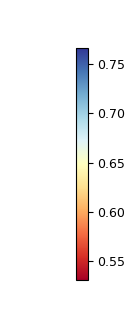

In [45]:
# Make stylized table
results_df_colored = results_baseline_df.style.format("{:.4f}").background_gradient(
    axis=None, cmap="RdYlBu").set_table_styles(
    [
        {'selector': 'th', 'props': [('padding', '10px')]},  # Header padding
        {'selector': 'td', 'props': [('padding', '10px')]},   # Cell padding
        {'selector': 'th.row_heading', 'props': [('padding-left', '20px'), ('text-align', 'left')]},  # Row labels    
        ]
)

fig, ax = plt.subplots(figsize=(1,4))

# Create a colorbar data based on min and max values in the DataFrame
norm = plt.Normalize(results_baseline_df.min().min(), results_baseline_df.max().max())
sm = plt.cm.ScalarMappable(cmap="RdYlBu", norm=norm)
sm.set_array([])

# Remove the axis
ax.axis("off")

# Create the colorbar
fig.colorbar(sm, ax=ax)

# Save the colorbar to a PNG image and convert to base64
buf = BytesIO()
fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.1)
buf.seek(0)
colorbar_base64 = base64.b64encode(buf.read()).decode('utf-8')
colorbar_html = f'<img src="data:image/png;base64,{colorbar_base64}" style="margin-left: 20px;"/>'

# Combine the styled DataFrame and the colorbar
html = results_df_colored.to_html()
combined_html = f'<div style="display: flex; align-items: center;">{html}{colorbar_html}</div>'

# Display the combined output
display(HTML(combined_html))

# Close the figure to prevent it from displaying below the table
plt.close(fig)

dfi.export(results_df_colored,
           "../plots/mqi/results_df_1baseline.png",
           table_conversion='matplotlib'
          )

In [17]:
# Print highest and average of selected metric per model

print(f"Printing highest and average of {METRIC_NAME} per model:")
for col in results_baseline_df.columns:
    average = round(results_baseline_df[col].mean(), 5)

    print(f"{col}:")
    print(f"    ----- Highest score: {results_baseline_df[col].max()}")
    print(f"    ----- Average score: {average}")

Printing highest and average of ROC AUC per model:
MLP:
    ----- Highest score: 0.76635
    ----- Average score: 0.74985
SGD:
    ----- Highest score: 0.75688
    ----- Average score: 0.74575
KNN:
    ----- Highest score: 0.67183
    ----- Average score: 0.65604
SVM:
    ----- Highest score: 0.72892
    ----- Average score: 0.69943
GB:
    ----- Highest score: 0.74422
    ----- Average score: 0.72763
NB:
    ----- Highest score: 0.71335
    ----- Average score: 0.69804
DT:
    ----- Highest score: 0.60796
    ----- Average score: 0.59397
RF:
    ----- Highest score: 0.7401
    ----- Average score: 0.71745


Best performers for mqi are MLP, SGD, RF, GB, and SVM. I will select the 3 best for both use cases (sarcopenia and MQI), which are **MLP**, **SVM**, and **RF**.

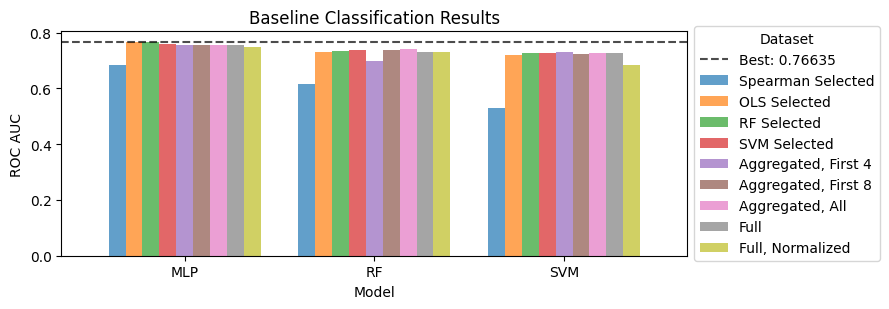

In [18]:
# Select specific models and re-arrange column order
results_baseline_df = results_baseline_df.reindex(columns=['MLP','RF','SVM'])
max_value = results_baseline_df.max().max()

# Plot results of the best 3 models
fig, ax = plt.subplots(figsize=(9, 3.2))

results_baseline_df.transpose().plot.bar(ax=ax, rot=0, width=.8, alpha=.7)
ax.set_title('Baseline Classification Results')
ax.set_ylabel(METRIC_NAME)
ax.set_xlabel('Model')
plt.axhline(y=max_value, color='black', linestyle='--', alpha=0.7, label=f"Best: {max_value:.5f}")
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), title='Dataset')

fig.tight_layout()
plt.savefig('../plots/mqi/results_1baseline.png')

# 2. Hyperparameter Tuning

## SVM - Ajuste de Hiperparámetros

In [19]:
# Dictionary of hyperparameters for SVM
svm_params = {
    'svm__C':[1.0, 10.0, 100.0],    # Strength of regularization (larger # = smaller margin)
    'svm__kernel':['rbf', 'linear', 'poly', 'sigmoid'],
    'svm__degree':[3, 4, 5, 6],     # Degree of poly kernel, ignored by others
    'svm__class_weight':[None, 'balanced'],
    'svm__random_state' : [42],            # For reproducibility
    'svm__probability': [True]
}

# Create pipeline to scale data and pipeline
svm_pipe = Pipeline(steps=[("scaler", StandardScaler()), ("svm", svm.SVC())])

In [20]:
# Run hyperparameter tuning for SVM
results_svm, best_params_svm, best_model_svm, best_score_svm, cv_results_svm = fn.gridsearch(
    datasets_hpt,
    Y_mqi,
    svm_params,
    svm_pipe
)

# Print best model(s) and best score
print(f"Best model: {best_model_svm}\nBest Score: {best_score_svm}")

  0%|          | 0/9 [00:00<?, ?it/s]

{'svm__C': 1.0, 'svm__class_weight': 'balanced', 'svm__degree': 3, 'svm__kernel': 'linear', 'svm__probability': True, 'svm__random_state': 42}
{'svm__C': 100.0, 'svm__class_weight': 'balanced', 'svm__degree': 3, 'svm__kernel': 'poly', 'svm__probability': True, 'svm__random_state': 42}
{'svm__C': 1.0, 'svm__class_weight': 'balanced', 'svm__degree': 3, 'svm__kernel': 'linear', 'svm__probability': True, 'svm__random_state': 42}
{'svm__C': 1.0, 'svm__class_weight': 'balanced', 'svm__degree': 3, 'svm__kernel': 'linear', 'svm__probability': True, 'svm__random_state': 42}
{'svm__C': 1.0, 'svm__class_weight': 'balanced', 'svm__degree': 3, 'svm__kernel': 'linear', 'svm__probability': True, 'svm__random_state': 42}
{'svm__C': 1.0, 'svm__class_weight': 'balanced', 'svm__degree': 3, 'svm__kernel': 'linear', 'svm__probability': True, 'svm__random_state': 42}
{'svm__C': 10.0, 'svm__class_weight': 'balanced', 'svm__degree': 3, 'svm__kernel': 'linear', 'svm__probability': True, 'svm__random_state': 42

In [21]:
# Create DF of best parameters per dataset
best_params_svm_df = pd.DataFrame(best_params_svm.items(), columns=['dataset', 'parameters'])
best_params_svm_df.set_index('dataset', inplace=True)  # Set dataset as index

# Create df of gridsearch results
cv_results_svm_df = pd.DataFrame.from_dict(cv_results_svm)

# Export to csv's
best_params_svm_df.to_csv('../results/mqi/best_params_per_dataset_svm.csv')
cv_results_svm_df.to_csv('../results/mqi/cv_results_svm_df.csv')
results_svm.to_csv('../results/mqi/classification_svm_results.csv')

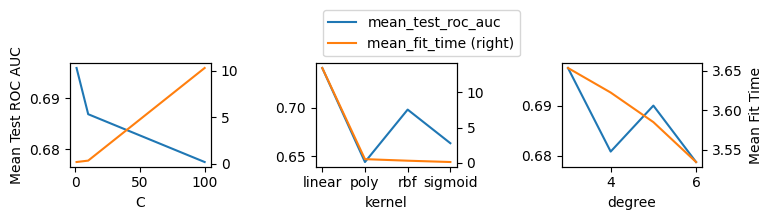

In [22]:
# Plot hyperparameter tuning results
# These results only show the results from the last dataset (X_selected_all)
cv_results_svm = pd.read_csv('../results/mqi/cv_results_svm_df.csv')

hyperparameters = ['svm__C', 'svm__kernel', 'svm__degree']
param_name = ['C', 'kernel', 'degree']

n_hyperparameters = len(hyperparameters)
results = pd.DataFrame(cv_results_svm)
results[RESULTS_MEAN_METRIC] = results[RESULTS_MEAN_METRIC].astype('float64').round(2)

fig, axs = plt.subplots(1, n_hyperparameters, figsize=(8, 2.3))

for i, hyperparameter in enumerate(hyperparameters):
    results_mean = results.pivot_table(index='param_' + hyperparameter, values=RESULTS_MEAN_METRIC)
    time_mean = results.pivot_table(index='param_' + hyperparameter, values='mean_fit_time')
    results_mean.plot(ax=axs[i], legend=True, label='Mean Score')
    time_mean.plot(ax=axs[i], legend=True, secondary_y=True, label='Mean Fit Time')

    axs[i].set_xlabel(param_name[i])
    
axs[0].set_ylabel(f"Mean Test {METRIC_NAME}")
axs[2].right_ax.set_ylabel('Mean Fit Time')

axs[0].get_legend().remove()
axs[1].get_legend().set_bbox_to_anchor((0., 1, 1., .102))
axs[2].get_legend().remove()

plt.tight_layout()
plt.savefig('../plots/mqi/results_2svm.png')
plt.show()

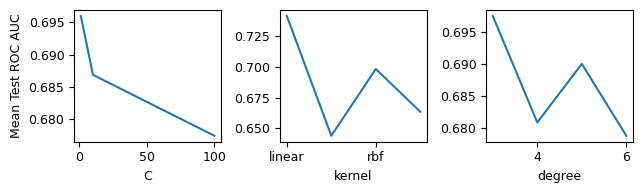

In [57]:
# Plot hyperparameter tuning results
# These results only show the results from the last dataset (X_selected_all)
cv_results_svm = pd.read_csv('../results/mqi/cv_results_svm_df.csv')

hyperparameters = ['svm__C', 'svm__kernel', 'svm__degree']
param_name = ['C', 'kernel', 'degree']

n_hyperparameters = len(hyperparameters)
results = pd.DataFrame(cv_results_svm)
results[RESULTS_MEAN_METRIC] = results[RESULTS_MEAN_METRIC].astype('float64').round(2)

fig, axs = plt.subplots(1, n_hyperparameters, figsize=(6.5, 2))

for i, hyperparameter in enumerate(hyperparameters):
    ax = axs[i] if n_hyperparameters > 1 else axs
    results_mean = results.pivot_table(index='param_' + hyperparameter, values=RESULTS_MEAN_METRIC)
    results_mean.plot(ax=ax, legend=False)

    ax.set_xlabel(param_name[i])
axs[0].set_ylabel(f"Mean Test {METRIC_NAME}")

plt.tight_layout()
plt.savefig('../plots/mqi/results_2svm.png', dpi=300)
plt.show()

In [ ]:
fig, axs = plt.subplots(1, n_hyperparameters, figsize=(6.5, 2))

for i, hyperparameter in enumerate(hyperparameters):
    ax = axs[i] if n_hyperparameters > 1 else axs
    results_mean = results.pivot_table(index='param_' + hyperparameter, values=RESULTS_MEAN_METRIC)
    results_mean.plot(ax=ax, legend=False)

    ax.set_xlabel(param_name[i])
axs[0].set_ylabel(f"Mean Test {METRIC_NAME}")

plt.tight_layout()
plt.savefig('../plots/sarco/results_2svm.png', dpi=300)
plt.show()

## RFC - Ajuste de Hiperparámetros

In [24]:
# Dictionary of hyperparameters
rfc_params = {
    'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200],
    'max_features':['sqrt', 'log2', None],
    'random_state':[42],
    'class_weight':['balanced', None],
}

In [25]:
# Run hyperparameter tuning for RFC
results_rfc, best_params_rfc, best_model_rfc, best_score_rfc, cv_results_rfc = fn.gridsearch(
    datasets_hpt,
    Y_mqi,
    rfc_params,
    RandomForestClassifier())

# Print best model(s) and best score
print(f"Best model: {best_model_rfc}\nBest Score: {best_score_rfc}")

  0%|          | 0/9 [00:00<?, ?it/s]

{'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42}
{'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42}
{'class_weight': None, 'max_features': None, 'n_estimators': 200, 'random_state': 42}
{'class_weight': None, 'max_features': None, 'n_estimators': 200, 'random_state': 42}
{'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42}
{'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 64, 'random_state': 42}
{'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42}
{'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42}
{'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42}
------ DONE ------
Best model: ['RandomForestClassifier():X_selected_8']
Best Score: 0.74194


In [26]:
# Create df of best parameters per dataset
best_params_rfc_df = pd.DataFrame(best_params_rfc.items(),
                                  columns=['dataset', 'parameters'])
best_params_rfc_df.set_index('dataset', inplace=True)  # Set dataset as index

# Create df of gridsearch results
cv_results_rfc_df = pd.DataFrame.from_dict(cv_results_rfc)

# Export as csv's
best_params_rfc_df.to_csv('../results/mqi/best_params_per_dataset_rfc.csv')
results_rfc.to_csv('../results/mqi/classification_rfc_results.csv')
cv_results_rfc_df.to_csv('../results/mqi/cv_results_rfc_df.csv')

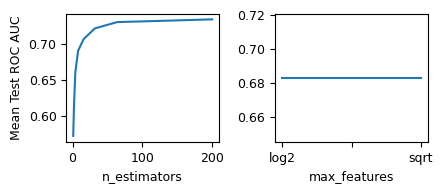

In [55]:
# Plot RF hyperparameter tuning results
# These results only show the results from the last dataset (X_selected_all)
hyperparameters = ['n_estimators', 'max_features']

n_hyperparameters = len(hyperparameters)
results = pd.DataFrame(cv_results_rfc)

fig, axs = plt.subplots(1, n_hyperparameters, figsize=(4.5, 2))

for i, hyperparameter in enumerate(hyperparameters):
    ax = axs[i] if n_hyperparameters > 1 else axs
    results_mean = results.pivot_table(index='param_' + hyperparameter, values=RESULTS_MEAN_METRIC)
    results_mean.plot(ax=ax, legend=False)

    ax.set_xlabel(hyperparameter)
axs[0].set_ylabel(f"Mean Test {METRIC_NAME}")

plt.tight_layout()
plt.savefig('../plots/mqi/results_2rf.png', dpi=300)
plt.show()

## MLP - Ajuste de Hiperparámetros

In [28]:
# Dictionary of hyperparameters for MLP
layer_sizes = [(10,), (100,), (200,), (10,10), (10,100), (100,100), (10,10,10), (100,100,100)]

mlp_params = {
    'mlp__hidden_layer_sizes':layer_sizes, # number of hidden layers
    'mlp__activation':['logistic', 'tanh', 'relu'],  # Activation function
    'mlp__learning_rate':['constant', 'adaptive'],   # Constant is best, remove 'adaptive'
    'mlp__max_iter':[5000], # With adam, 5000 is enough, but not with lbfgs
    'mlp__random_state':[42]
}

# Create pipeline to scale data and pipeline
mlp_pipe = Pipeline(steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier())])

In [29]:
# Run hyperparameter tuning for MLP
results_mlp, best_params_mlp, best_model_mlp, best_score_mlp, cv_results_mlp = fn.gridsearch(
    datasets_hpt,
    Y_mqi,
    mlp_params,
    mlp_pipe
)

# Print best model(s) and score
print(f"Best model: {best_model_mlp}\nBest Score: {best_score_mlp}")

  0%|          | 0/9 [00:00<?, ?it/s]

{'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': (200,), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 5000, 'mlp__random_state': 42}
{'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': (100, 100), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 5000, 'mlp__random_state': 42}
{'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': (10,), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 5000, 'mlp__random_state': 42}
{'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 5000, 'mlp__random_state': 42}
{'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': (200,), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 5000, 'mlp__random_state': 42}
{'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (10, 10, 10), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 5000, 'mlp__random_state': 42}
{'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (10, 10, 10), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 5

In [30]:
# Create df for best hyperparams per dataset
best_params_mlp_df = pd.DataFrame(best_params_mlp.items(),
                                  columns=['dataset', 'parameters']
                                 )
best_params_mlp_df.set_index('dataset', inplace=True)  # Set datset as index

# Create df of gridsearch results
cv_results_mlp_df = pd.DataFrame.from_dict(cv_results_mlp)

# Export as csv
best_params_mlp_df.to_csv('../results/mqi/best_params_per_dataset_mlp.csv')
results_mlp.to_csv('../results/mqi/classification_mlp_results.csv')
cv_results_mlp_df.to_csv('../results/mqi/cv_results_mlp_df.csv')


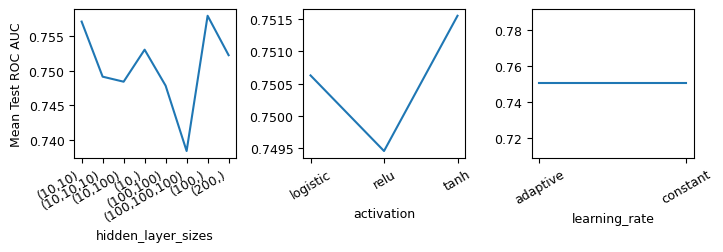

In [56]:
# Plot hyperparameter tuning results
# These results only show the results from the last dataset (X_selected_all)
cv_results_mlp = pd.read_csv('../results/mqi/cv_results_mlp_df.csv')

# Change font size
plt.rcParams.update({'font.size': 9})

# Plot MLP hyperparameter tuning results
hyperparameters = ['mlp__hidden_layer_sizes', 'mlp__activation', 'mlp__learning_rate']
param_name = ['hidden_layer_sizes', 'activation', 'learning_rate']

n_hyperparameters = len(hyperparameters)
results = pd.DataFrame(cv_results_mlp)

fig, axs = plt.subplots(1, n_hyperparameters, figsize=(7.3, 2.6))

for i, hyperparameter in enumerate(hyperparameters):
    ax = axs[i] if n_hyperparameters > 1 else axs
    results_mean = results.pivot_table(index='param_' + hyperparameter, values=RESULTS_MEAN_METRIC)
    results_mean.plot(ax=ax, legend=False, rot=30)

    ax.set_xlabel(param_name[i])
axs[0].set_ylabel(f"Mean Test {METRIC_NAME}")

plt.setp(axs[0].get_xticklabels(), ha="right")

axs[0].set_xticks([0,1,2,3,4,5,6,7])
labels = ['(10,10)','(10,10,10)','(10,100)','(10,)','(100,100)','(100,100,100)','(100,)','(200,)']
axs[0].set_xticklabels(labels)

axs[2].set_xticks([0,1])
axs[2].set_xticklabels(['adaptive','constant'])

plt.tight_layout()
plt.savefig('../plots/mqi/results_2mlp.png', dpi=300)
plt.show()

## Hyperparameter Tuning Results

### Load and concat results

In [8]:
# Load hyperparam classification results
results_svm = pd.read_csv('../results/mqi/classification_svm_results.csv', index_col=0)
results_svm.rename({METRIC:'svm'}, inplace=True, axis=1)
results_svm = pd.DataFrame(results_svm['svm'])

results_rfc = pd.read_csv('../results/mqi/classification_rfc_results.csv', index_col=0)
results_rfc.rename({METRIC:'rfc'}, inplace=True, axis=1)
results_rfc = pd.DataFrame(results_rfc['rfc'])

results_mlp = pd.read_csv('../results/mqi/classification_mlp_results.csv', index_col=0)
results_mlp.rename({METRIC:'mlp'}, inplace=True, axis=1)
results_mlp = pd.DataFrame(results_mlp['mlp'])

# Concat into one df
gridsearch_results = pd.concat([results_mlp, results_rfc, results_svm ], axis=1)

### Make column and index names more presentable

In [9]:
# Rename columns
column_names = {'mlp': 'Multi-Layer Perceptron',
                'rfc': 'Random Forest Classifier',
                'svm': 'Support Vector Machine'}

column_names = {'mlp': 'MLP',
                'rfc': 'RF',
                'svm': 'SVM'}

gridsearch_results.rename(columns=column_names, inplace=True)

# Add Column for dataset names and set as index
index_names = ['Full', 'Spearman Select', 'OLS Select',
               'RF Select', 'Full Normalized',
               'SVM Select', 'Aggregated First 4',
               'Aggregated First 8', 'Aggregated All']

gridsearch_results['Dataset'] = index_names
gridsearch_results.set_index('Dataset', inplace=True)

# Change index order
index_order = ['Spearman Select', 'OLS Select', 'RF Select',
               'SVM Select', 'Aggregated First 4', 'Aggregated First 8',
               'Aggregated All', 'Full',  'Full Normalized']

gridsearch_results = gridsearch_results.reindex(index = index_order)

### Plot results

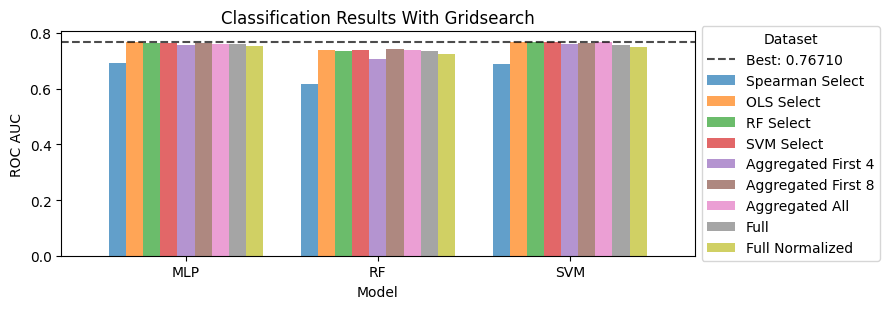

In [10]:
max_value = gridsearch_results.max().max()

fig, ax = plt.subplots(figsize=(9,3.2))
gridsearch_results.transpose().plot.bar(ax=ax, rot=0, width=.8, alpha=.7)
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.set_title('Classification Results With Gridsearch')
ax.set_ylabel(METRIC_NAME)
ax.set_xlabel('Model')

plt.axhline(y=max_value, color='black', linestyle='--', alpha=0.7, label=f"Best: {max_value:.5f}")
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), title='Dataset')

fig.tight_layout()
plt.savefig('../plots/mqi/results_2gridsearch.png')

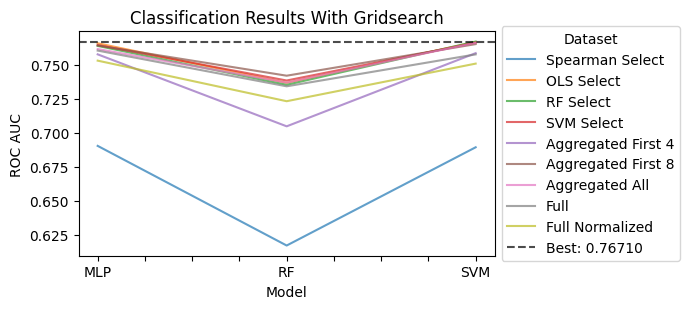

In [11]:
fig, ax = plt.subplots(figsize=(7,3.2))
gridsearch_results.transpose().plot.line(ax=ax, rot=0, alpha=.7)
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.set_title('Classification Results With Gridsearch')
ax.set_ylabel(METRIC_NAME)
ax.set_xlabel('Model')

plt.axhline(y=max_value, color='black', linestyle='--', alpha=0.7, label=f"Best: {max_value:.5f}")
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), title='Dataset')


fig.tight_layout()
plt.savefig('../plots/mqi/results_2gridsearch2.png')

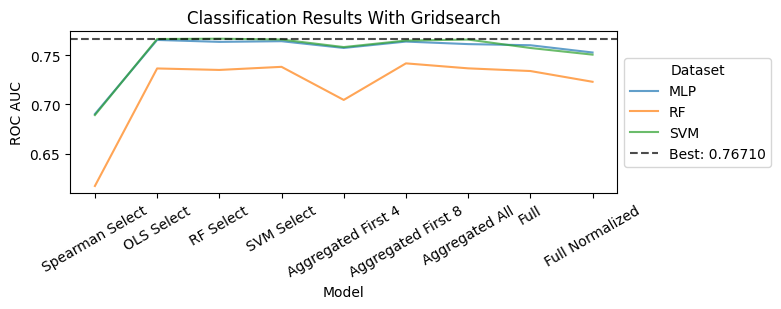

In [16]:
fig, ax = plt.subplots(figsize=(8,3.2))
gridsearch_results.plot.line(ax=ax, rot=30, alpha=.7)
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.set_title('Classification Results With Gridsearch')
ax.set_ylabel(METRIC_NAME)
ax.set_xlabel('Model')

plt.axhline(y=max_value, color='black', linestyle='--', alpha=0.7, label=f"Best: {max_value:.5f}")
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), title='Dataset')


fig.tight_layout()
plt.savefig('../plots/mqi/results_2gridsearch2.png')

,MLP,RF,SVM
Dataset,,,
Spearman Select,0.6903,0.6169,0.6892
OLS Select,0.7658,0.7368,0.7668
RF Select,0.7639,0.7352,0.7671
SVM Select,0.7645,0.7384,0.7662
Aggregated First 4,0.7577,0.7047,0.7585
Aggregated First 8,0.7642,0.7419,0.7652
Aggregated All,0.7616,0.7369,0.7662
Full,0.7604,0.7341,0.7576
Full Normalized,0.7530,0.7231,0.7508

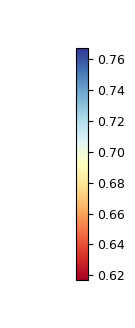

In [99]:
# Create stylized table
gridsearch_results_colored = gridsearch_results.style.format("{:.4f}").background_gradient(
    axis=None,
    cmap="RdYlBu",
)

fig, ax = plt.subplots(figsize=(1,4))
norm = plt.Normalize(gridsearch_results.min().min(), gridsearch_results.max().max())
sm = plt.cm.ScalarMappable(cmap="RdYlBu", norm=norm)
sm.set_array([])

# Remove the axis
ax.axis("off")

# Create the colorbar
fig.colorbar(sm, ax=ax)

# Save the colorbar to a PNG image and convert to base64
buf = BytesIO()
fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.1)
buf.seek(0)
colorbar_base64 = base64.b64encode(buf.read()).decode('utf-8')
colorbar_html = f'<img src="data:image/png;base64,{colorbar_base64}" style="margin-left: 20px;"/>'

# Combine the styled DataFrame and the colorbar
html = gridsearch_results_colored.to_html()
combined_html = f'<div style="display: flex; align-items: center;">{html}{colorbar_html}</div>'

# Display the combined output
display(HTML(combined_html))

# Close the figure to prevent it from displaying below the table
plt.close(fig)

dfi.export(gridsearch_results_colored,
           "../plots/mqi/results_df_2gridsearch.png",
           table_conversion='matplotlib',
           dpi=300
          )

## Load final results to join dataframe

In [151]:
metrics = ['roc_auc', 'f1', 'accuracy', 'dataset']

results_svm = pd.read_csv('../results/mqi/classification_svm_results.csv')
results_svm = results_svm[metrics]
# Melt the DataFrame to prepare for MultiIndex creation
results_svm = results_svm.melt(id_vars=['dataset'], var_name='metrics', value_name='svm')
results_svm = results_svm.set_index(['dataset', 'metrics'])  # Set the MultiIndex
results_svm = results_svm.sort_index()

results_rfc = pd.read_csv('../results/mqi/classification_rfc_results.csv')
results_rfc = results_rfc[metrics]
# Melt the DataFrame to prepare for MultiIndex creation
results_rfc = results_rfc.melt(id_vars=['dataset'], var_name='metrics', value_name='rfc')
results_rfc = results_rfc.set_index(['dataset', 'metrics'])  # Set the MultiIndex
results_rfc = results_rfc.sort_index()

results_mlp = pd.read_csv('../results/mqi/classification_mlp_results.csv')
results_mlp = results_mlp[metrics]
# Melt the DataFrame to prepare for MultiIndex creation
results_mlp = results_mlp.melt(id_vars=['dataset'], var_name='metrics', value_name='mlp')
results_mlp = results_mlp.set_index(['dataset', 'metrics'])  # Set the MultiIndex
results_mlp = results_mlp.sort_index()

results = pd.concat([results_svm, results_rfc, results_mlp], axis=1)
results = results.round(4)
results.to_csv('../results/mqi/classification_results_all.csv')
results

svm     rfc     mlp
dataset        metrics                         
X_cor_ols      accuracy  0.7668  0.7368  0.7658
               f1        0.5357  0.4901  0.4848
               roc_auc   0.7668  0.7368  0.7658
X_cor_pear     accuracy  0.6892  0.6169  0.6903
               f1        0.3787  0.3911  0.3617
               roc_auc   0.6892  0.6169  0.6903
X_forest       accuracy  0.7671  0.7352  0.7639
               f1        0.5383  0.4955  0.4771
               roc_auc   0.7671  0.7352  0.7639
X_mqi_datos    accuracy  0.7576  0.7341  0.7604
               f1        0.5328  0.4650  0.4674
               roc_auc   0.7576  0.7341  0.7604
X_mqi_norm     accuracy  0.7508  0.7232  0.7530
               f1        0.5291  0.4732  0.4790
               roc_auc   0.7508  0.7232  0.7530
X_selected_4   accuracy  0.7585  0.7047  0.7577
               f1        0.5420  0.4664  0.4566
               roc_auc   0.7585  0.7047  0.7577
X_selected_8   accuracy  0.7652  0.7419  0.7642
               f1        0.5388  0.4787  0.4707
               roc_auc   0.7652  0.7419  0.7642
X_selected_all accuracy  0.7662  0.7369  0.7616
               f1        0.5466  0.4898  0.4691
               roc_auc   0.7662  0.7369  0.7616
X_svm          accuracy  0.7662  0.7384  0.7645
               f1        0.5466  0.4988  0.4575
               roc_auc   0.7662  0.7384  0.7645